# Bluecoats Phase 1: Program Evaluation - HTB Closing Ceremonies
### Bluecoats impact on staff hope, trust, and belonging
#### Question: Throuhout the program, did the actions of the Bluecoats - engaging, communicating, advocating, and taking action - have an impact on your hope, trust, and belonging?
* Yes, there were 65 participants at the closing ceremonies and 209 responses indicating that hope, trust, and belonging - or some combination of the three - were positively impacted.

In [1]:
# Modules
from bluecoats_p1_config import *

import pandas as pd
import numpy as np
from scipy import stats

import re
import copy
import math
import random
import datetime
from collections import defaultdict

import glob
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as col
from matplotlib import colormaps as colmap
import seaborn as sns; 
import plotly.graph_objects as go
import plotly.express as px

sns.set()
%matplotlib inline

# Pandas view options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.precision', 4)

# Jupyter display options
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

# Program Parameters

## Constants

In [3]:
SAVE_DATE_STR = '20230811'
SAVE_DPI = 200 # override default save dpi

## Collections

In [4]:
actions_cols_ordered = ['engaging','communicating','advocating','taking_action','all']
feelings_cols_ordered = ['hope','trust','belonging','hope_trust','hope_belonging','trust_belonging','hope_trust_belonging']

feelings_dict = {'hope':(1,0,0), 'trust':(0,1,0), 'belonging':(0,0,1), 'hope_trust':(1,1,0), 'hope_belonging':(1,0,1), 
                 'trust_belonging':(0,1,1), 'hope_trust_belonging':(1,1,1)}

In [5]:
# Dictionaries for labeling time
month_dict = dict({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
                   7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec',})
day_name_dict = dict({0:'Mon',1:'Tues',2:'Wed',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'})

hour_suffix = ['AM']*12 +['PM']*12
hour_vals_24 = [val for val in range(0,24)]
hour_vals_12 = [val%12+12 if val%12==0 else val%12 for val in range(0,24)]
hour_labels = [str(val)+suffix for val,suffix in zip(hour_vals_12,hour_suffix)]
hour_dict = dict(zip(hour_vals_24,hour_labels))

In [ ]:
# Custom colormaps
cdict_dark_blues = {
     'red': ((0.0, 0.0, 0.0),
             (1.0, 0.0, 0.0)),
     'green': ((0.0, 0.0, 0.0),
               (1.0, 0.0, 0.0)),
     'blue': ((0.0, 0.3, 0.3),
              (1.0, 0.9, 0.9))}
dark_blues = col.LinearSegmentedColormap('my_blue_map', cdict_dark_blues, N=256, gamma=1)
colmap.register(name='blue', cmap=dark_blues)

cdict_dark_reds = {
     'red': ((0.0, 0.3, 0.3),
             (1.0, 0.9, 0.9)),
     'green': ((0.0, 0.0, 0.0),
               (1.0, 0.0, 0.0)),
     'blue': ((0.0, 0.0, 0.0),
              (1.0, 0.0, 0.0))}
dark_reds = col.LinearSegmentedColormap('my_red_map', cdict_dark_reds, N=256, gamma=1)
colmap.register(name='red', cmap=dark_reds)

# Read Data

In [7]:
htb_categorical_closing_master = pd.read_csv(RAW_HTB_PATH + 'htb_closing_20230807_20230811.csv')

responses = htb_categorical_closing_master[['response_id']]
actions = pd.get_dummies(htb_categorical_closing_master['action'])
feelings = pd.get_dummies(htb_categorical_closing_master['feeling'])
feelings_combined = pd.DataFrame(htb_categorical_closing_master['feeling'].map(feelings_dict).to_list(), columns=['hope','trust','belonging'])

htb_expanded_closing_master = pd.concat([responses,actions,feelings], axis=1)
htb_combined_closing_master = pd.concat([responses,actions,feelings_combined], axis=1)

In [8]:
print(len(htb_categorical_closing_master))
print(len(htb_categorical_closing_master.columns))
htb_categorical_closing_master.tail(2)

209
3


,response_id,action,feeling
207,resp_0207,taking_action,hope_trust_belonging
208,resp_0208,taking_action,hope_trust_belonging


In [9]:
print(len(htb_expanded_closing_master))
print(len(htb_expanded_closing_master.columns))
htb_expanded_closing_master.tail(2)

209
13


,response_id,advocating,all,communicating,engaging,taking_action,belonging,hope,hope_belonging,hope_trust,hope_trust_belonging,trust,trust_belonging
207,resp_0207,0,0,0,0,1,0,0,0,0,1,0,0
208,resp_0208,0,0,0,0,1,0,0,0,0,1,0,0


In [10]:
print(len(htb_combined_closing_master))
print(len(htb_combined_closing_master.columns))
htb_combined_closing_master.tail(2)

209
9


,response_id,advocating,all,communicating,engaging,taking_action,hope,trust,belonging
207,resp_0207,0,0,0,0,1,1,1,1
208,resp_0208,0,0,0,0,1,1,1,1


In [39]:
# Save master data
save_name = MASTER_HTB_PATH + 'htb_categorical_closing_master_'+ SAVE_DATE_STR + '.csv'
htb_categorical_closing_master.to_csv(save_name)

In [40]:
save_name = MASTER_HTB_PATH + 'htb_expanded_closing_master_'+ SAVE_DATE_STR + '.csv'
htb_expanded_closing_master.to_csv(save_name)

In [41]:
save_name = MASTER_HTB_PATH + 'htb_combined_closing_master_'+ SAVE_DATE_STR + '.csv'
htb_combined_closing_master.to_csv(save_name)

# Exploratory Analysis

In [206]:
idx_slice = pd.IndexSlice

## Totals

In [11]:
htb_categorical_closing_master['action'].value_counts()

taking_action    48
advocating       45
engaging         44
communicating    42
all              30
Name: action, dtype: int64

In [12]:
htb_expanded_closing_master.sum().iloc[1:]

advocating              45
all                     30
communicating           42
engaging                44
taking_action           48
belonging                6
hope                    30
hope_belonging          18
hope_trust              44
hope_trust_belonging    64
trust                   26
trust_belonging         21
dtype: object

Text(0.5, 1.0, 'Feelings: Total Number of Responses')

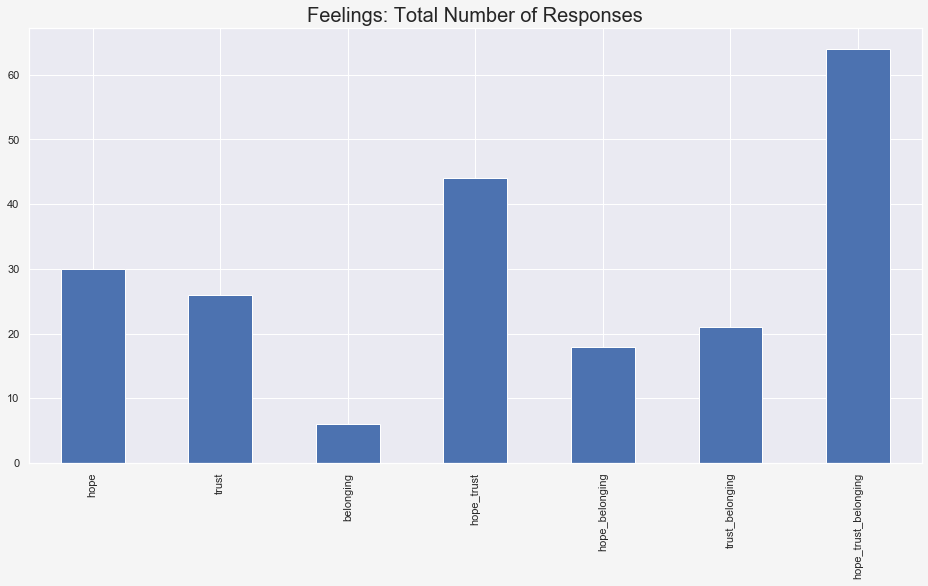

In [128]:
fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
a = htb_expanded_closing_master.sum().loc[feelings_cols_ordered].plot(ax=ax,kind='bar')

title = 'Feelings: Total Number of Responses'
a.set_title(title,fontsize=20)

Text(0.5, 1.0, 'Actions: Total Number of Responses ')

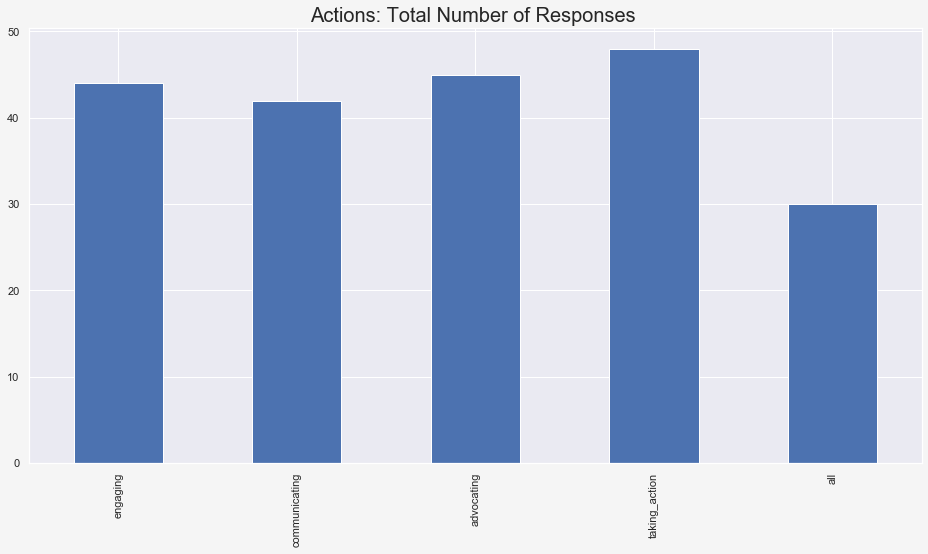

In [129]:
fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
a = htb_expanded_closing_master.sum().loc[actions_cols_ordered].plot(ax=ax,kind='bar')

title = 'Actions: Total Number of Responses '
a.set_title(title,fontsize=20)

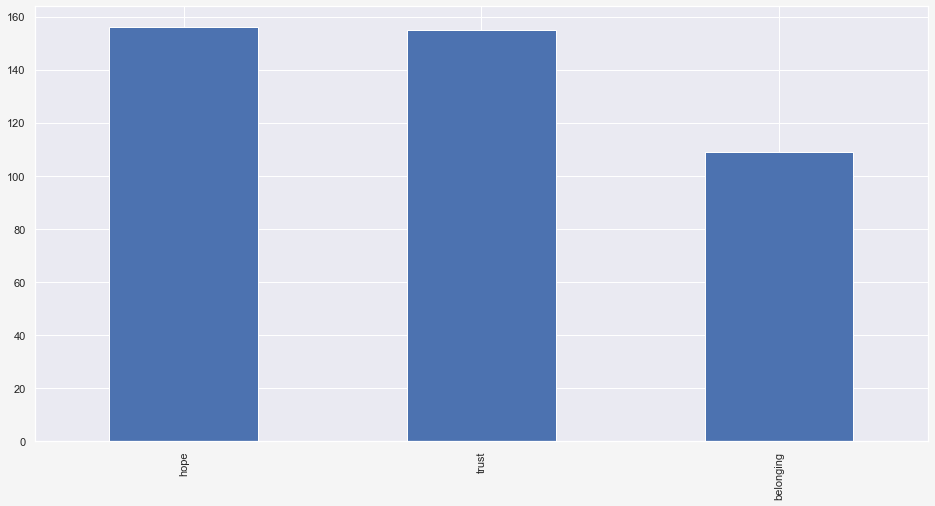

In [115]:
# any hope, trust, or belonging (single feeling OR >= 2 feeling selections)
# NOTE 2023/08/15: 
# is belonging tougher to move OR, maybe not as impacted by the specific projects done, OR may grow over time
fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
htb_combined_closing_master.sum().loc[['hope','trust','belonging']].plot(ax=ax, kind='bar')

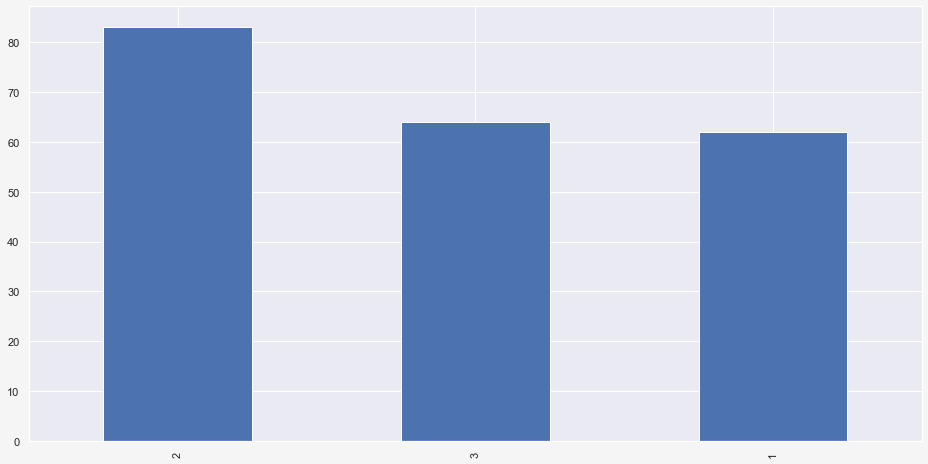

In [116]:
# Selections with 2 feelings expressed are most common!
fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
htb_combined_closing_master.loc[:,['hope','trust','belonging']].sum(axis=1).value_counts().plot(ax=ax, kind='bar')

## Actions and Feelings

### Stacked Bar Charts

In [93]:
feeling_action_summary = htb_categorical_closing_master.groupby(['feeling','action']).count().unstack().fillna(0).droplevel(axis=1,level=0).loc[feelings_cols_ordered,actions_cols_ordered]
feeling_action_summary

action,engaging,communicating,advocating,taking_action,all
feeling,,,,,
hope,11.0,7.0,3.0,1.0,8.0
trust,2.0,11.0,5.0,5.0,3.0
belonging,0.0,2.0,3.0,1.0,0.0
hope_trust,12.0,6.0,13.0,13.0,0.0
hope_belonging,5.0,4.0,6.0,3.0,0.0
trust_belonging,6.0,3.0,2.0,9.0,1.0
hope_trust_belonging,8.0,9.0,13.0,16.0,18.0


In [94]:
save_name = CHART_PATH + 'feeling_action_summary_'+ str(datetime.datetime.now().date()).replace('-','') + '.csv'
feeling_action_summary.to_csv(save_name)

Text(0, 0.5, 'Response Count')

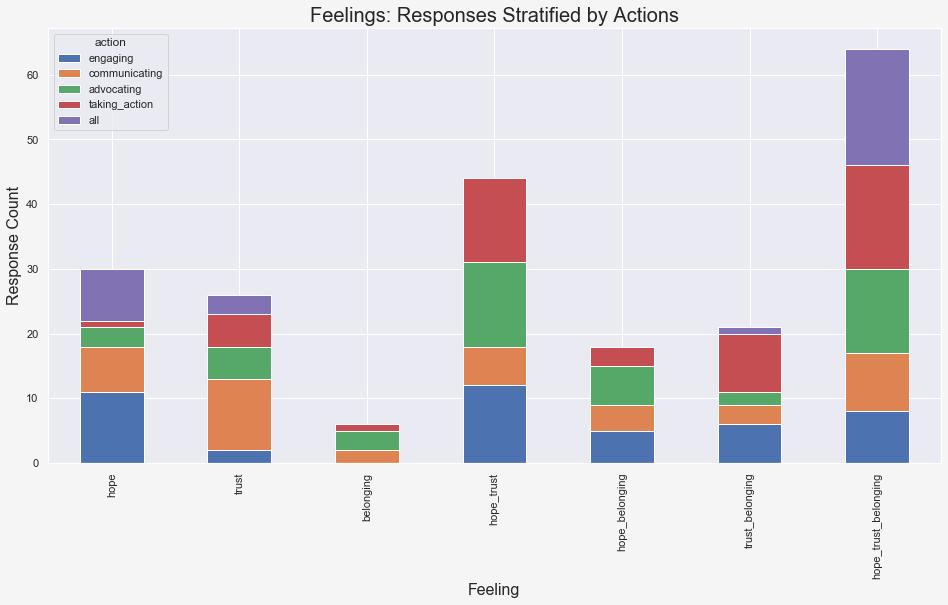

In [132]:
plot_data = feeling_action_summary
fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
a = plot_data.plot(ax=ax, kind='bar',stacked=True)

title = 'Feelings: Responses Stratified by Actions'
a.set_title(title,fontsize=20)
a.set_xlabel(a.get_xlabel().capitalize(), fontsize=16)
a.set_ylabel('Response Count',fontsize=16)

In [371]:
action_feeling_summary = htb_categorical_closing_master.groupby(['action','feeling']).count().unstack().fillna(0).droplevel(axis=1, level=0).loc[actions_cols_ordered,feelings_cols_ordered]
action_feeling_summary

feeling,hope,trust,belonging,hope_trust,hope_belonging,trust_belonging,hope_trust_belonging
action,,,,,,,
engaging,11.0,2.0,0.0,12.0,5.0,6.0,8.0
communicating,7.0,11.0,2.0,6.0,4.0,3.0,9.0
advocating,3.0,5.0,3.0,13.0,6.0,2.0,13.0
taking_action,1.0,5.0,1.0,13.0,3.0,9.0,16.0
all,8.0,3.0,0.0,0.0,0.0,1.0,18.0


In [97]:
save_name = CHART_PATH + 'action_feeling_summary'+ str(datetime.datetime.now().date()).replace('-','') + '.csv'
action_feeling_summary.to_csv(save_name)

In [438]:
plot_data

feeling,hope,trust,belonging,hope_trust,hope_belonging,trust_belonging,hope_trust_belonging
action,,,,,,,
engaging,11.0,2.0,0.0,12.0,5.0,6.0,8.0
communicating,7.0,11.0,2.0,6.0,4.0,3.0,9.0
advocating,3.0,5.0,3.0,13.0,6.0,2.0,13.0
taking_action,1.0,5.0,1.0,13.0,3.0,9.0,16.0
all,8.0,3.0,0.0,0.0,0.0,1.0,18.0


In [477]:
def get_labels(df, axis=0):
    labels = []
    raw_labels = [df.index,df.columns][axis]
    for label in raw_labels:
        if '_' in label:
            temp_label = ' '.join([item.capitalize() for item in label.split('_')])
            labels.append(temp_label)
        else:
            labels.append(label.capitalize())
    return labels

In [ ]:
plot_data = action_feeling_summary
fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
width =0.5
xtick_labels = get_labels(plot_data, axis=0)
bar_labels = get_labels(plot_data, axis=1)

In [474]:
xlabels

['Engaging', 'Communicating', 'Advocating', 'Taking Action', 'All']

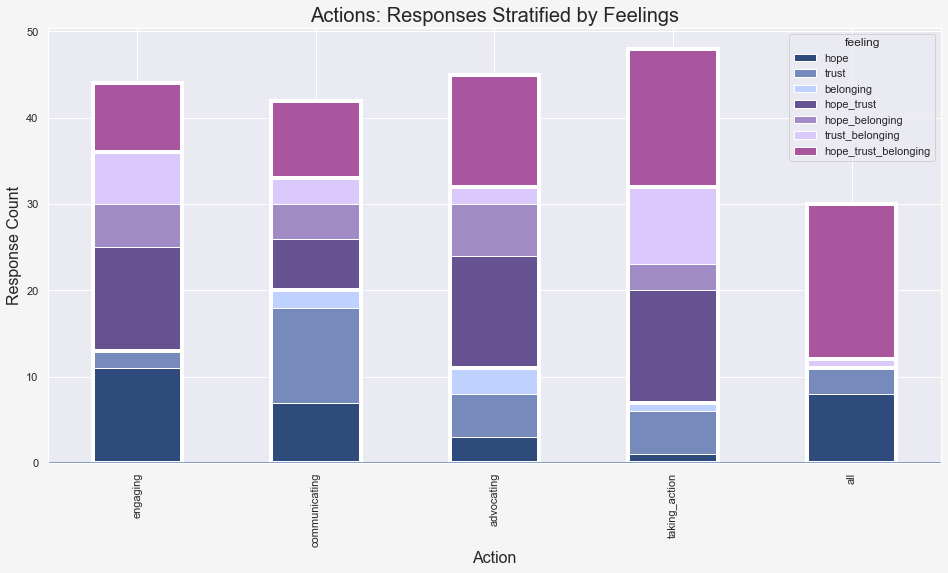

In [432]:
plot_data = action_feeling_summary
fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
width =0.5

# Single feelings 
single = plot_data[['hope','trust','belonging']].plot(ax=ax, kind='bar', stacked=True, width=width, color=['#2f4b7c', '#768bbc', '#bfd1ff'])
single_outline = plot_data[['hope','trust','belonging']].sum(axis=1).plot(ax=ax, kind='bar', width=width, color=(0,0,0,0), ec='white', lw=4)

# Double feelings
double = plot_data[['hope_trust','hope_belonging','trust_belonging']].plot(ax=ax, kind='bar', stacked=True, width=width, bottom=plot_data.loc[:,:'belonging'].sum(axis=1).values, color=['#665191', '#a08bc5', '#dcc9fc'])
double_outline = plot_data[['hope_trust','hope_belonging','trust_belonging']].sum(axis=1).plot(ax=ax, kind='bar', width=width, bottom=plot_data.loc[:,:'belonging'].sum(axis=1).values, color=(0,0,0,0), ec='white', lw=4)

# Triple feelings
triple = plot_data[['hope_trust_belonging']].plot(ax=ax, kind='bar', stacked=True, width=width, bottom=plot_data.loc[:,:'trust_belonging'].sum(axis=1).values, color='#aa569e')
triple_outline = plot_data[['hope_trust_belonging']].sum(axis=1).plot(ax=ax, kind='bar', width=width, bottom=plot_data.loc[:,:'trust_belonging'].sum(axis=1).values, color=(0,0,0,0), ec='white', lw=4)

title = 'Actions: Responses Stratified by Feelings'
ax.set_title(title,fontsize=20)
ax.set_xlabel(ax.get_xlabel().capitalize(), fontsize=16)
ax.set_ylabel('Response Count',fontsize=16)

ax.axhline()

In [421]:
for container in ax.containers:
    for bar in container:
        print(bar.get_height())

11.0
7.0
3.0
1.0
8.0
2.0
11.0
5.0
5.0
3.0
0.0
2.0
3.0
1.0
0.0
13.0
20.0
11.0
7.0
11.0
12.0
6.0
13.0
13.0
0.0
5.0
4.0
6.0
3.0
0.0
6.0
3.0
2.0
9.0
1.0
23.0
13.0
21.0
25.0
1.0
8.0
9.0
13.0
16.0
18.0
8.0
9.0
13.0
16.0
18.0


In [ ]:
ax.bar_label(p, label_type='center')

In [425]:
plot_data

feeling,hope,trust,belonging,hope_trust,hope_belonging,trust_belonging,hope_trust_belonging
action,,,,,,,
engaging,11.0,2.0,0.0,12.0,5.0,6.0,8.0
communicating,7.0,11.0,2.0,6.0,4.0,3.0,9.0
advocating,3.0,5.0,3.0,13.0,6.0,2.0,13.0
taking_action,1.0,5.0,1.0,13.0,3.0,9.0,16.0
all,8.0,3.0,0.0,0.0,0.0,1.0,18.0


In [311]:
plot_data.loc[:,:'belonging'].sum().sum()

62.0

Text(0, 0.5, 'Response Count')

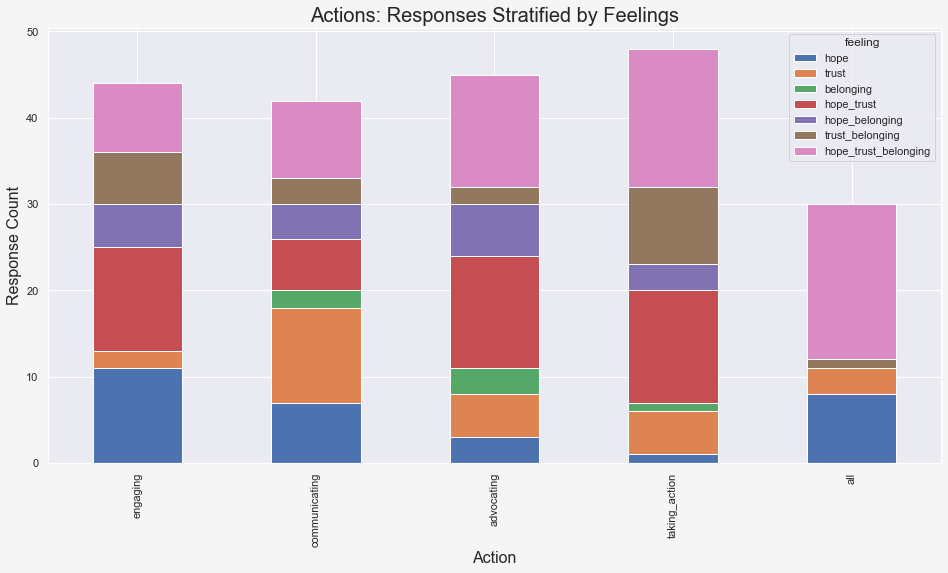

In [278]:
plot_data = action_feeling_summary
fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
a = plot_data.plot(ax=ax, kind='bar',stacked=True)

title = 'Actions: Responses Stratified by Feelings'
a.set_title(title,fontsize=20)
a.set_xlabel(a.get_xlabel().capitalize(), fontsize=16)
a.set_ylabel('Response Count',fontsize=16)

In [234]:
name = FIGURE_PATH + 'actions_feelings_' + str(datetime.datetime.now().date()).replace('-','')
formats = ['svg','png','pdf']
for file_format in formats:
    save_name = name + '.' + file_format
    fig.savefig(save_name,bbox_inches='tight', pad_inches=0, dpi=SAVE_DPI, transparent=True)

In [99]:
action_feelingCount_summary = htb_categorical_closing_master.copy()
action_feelingCount_summary['num_feelings_impacted'] = action_feelingCount_summary['feeling'].apply(lambda x: len(x.split('_')))
action_feelingCount_summary = action_feelingCount_summary.groupby(['action','num_feelings_impacted'])[['response_id']].count().unstack().fillna(0).droplevel(axis=1, level=0).loc[actions_cols_ordered]
action_feelingCount_summary

num_feelings_impacted,1,2,3
action,,,
engaging,13,23,8
communicating,20,13,9
advocating,11,21,13
taking_action,7,25,16
all,11,1,18


In [100]:
save_name = CHART_PATH + 'action_feelingCount_summary'+ str(datetime.datetime.now().date()).replace('-','') + '.csv'
action_feelingCount_summary.to_csv(save_name)

Text(0, 0.5, 'Response Count')

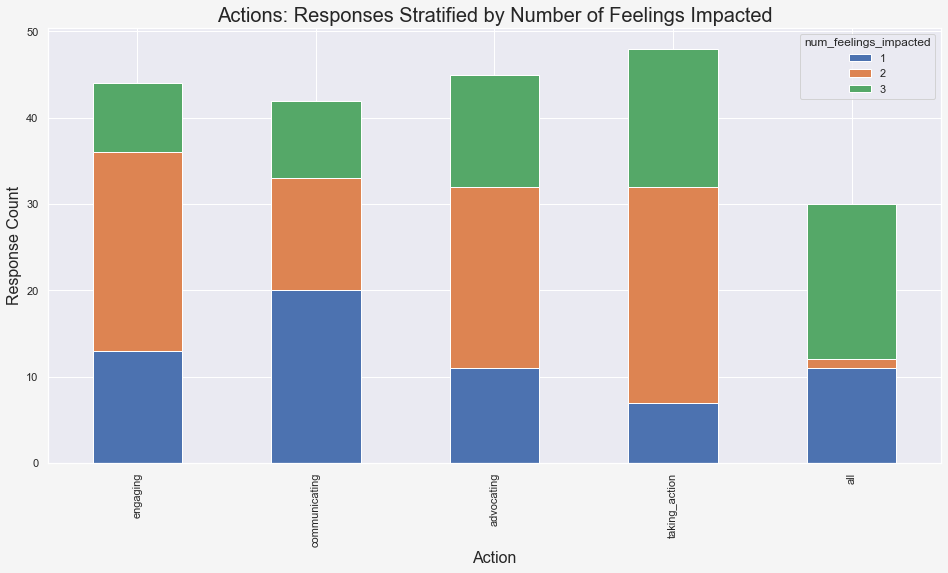

In [222]:
plot_data = action_feelingCount_summary
fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
a = plot_data.plot(ax=ax, kind='bar',stacked=True)

title = 'Actions: Responses Stratified by Number of Feelings Impacted'
a.set_title(title,fontsize=20)
a.set_xlabel(a.get_xlabel().capitalize(), fontsize=16)
a.set_ylabel('Response Count',fontsize=16)

Text(0, 0.5, 'Response Count')

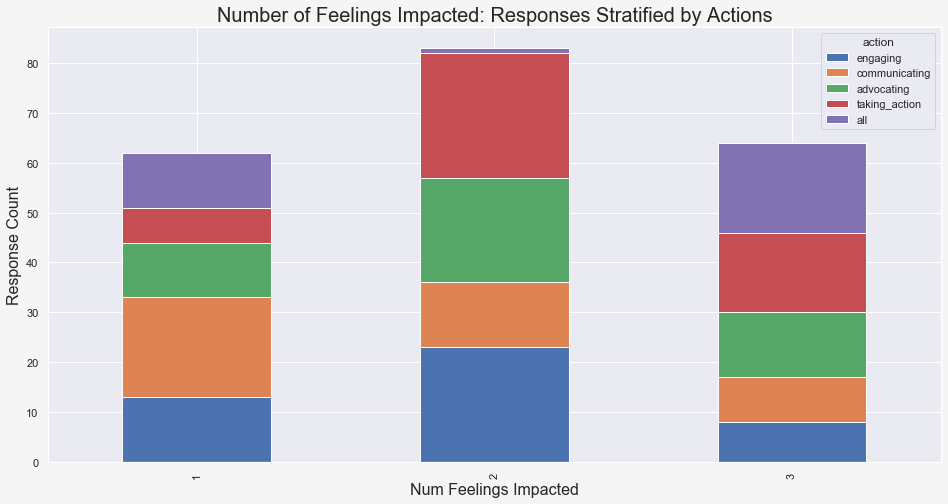

In [135]:
plot_data = action_feelingCount_summary.transpose()
fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
a = plot_data.plot(ax=ax, kind='bar',stacked=True)

title = 'Number of Feelings Impacted: Responses Stratified by Actions'
a.set_title(title,fontsize=20)
a.set_xlabel(' '.join([item.capitalize() for item in a.get_xlabel().split('_')]), fontsize=16)
a.set_ylabel('Response Count',fontsize=16)

In [209]:
feelings_feelingsCount_summary = htb_categorical_closing_master.copy()
feelings_feelingsCount_summary['num_feelings_impacted'] = feelings_feelingsCount_summary['feeling'].apply(lambda x: len(x.split('_')))
feelings_feelingsCount_summary = feelings_feelingsCount_summary.groupby(['feeling','num_feelings_impacted'])[['response_id']].count().unstack().fillna(0).droplevel(axis=1, level=0).loc[feelings_cols_ordered]
feelings_feelingsCount_summary

num_feelings_impacted,1,2,3
feeling,,,
hope,30.0,0.0,0.0
trust,26.0,0.0,0.0
belonging,6.0,0.0,0.0
hope_trust,0.0,44.0,0.0
hope_belonging,0.0,18.0,0.0
trust_belonging,0.0,21.0,0.0
hope_trust_belonging,0.0,0.0,64.0


Text(0, 0.5, 'Response Count')

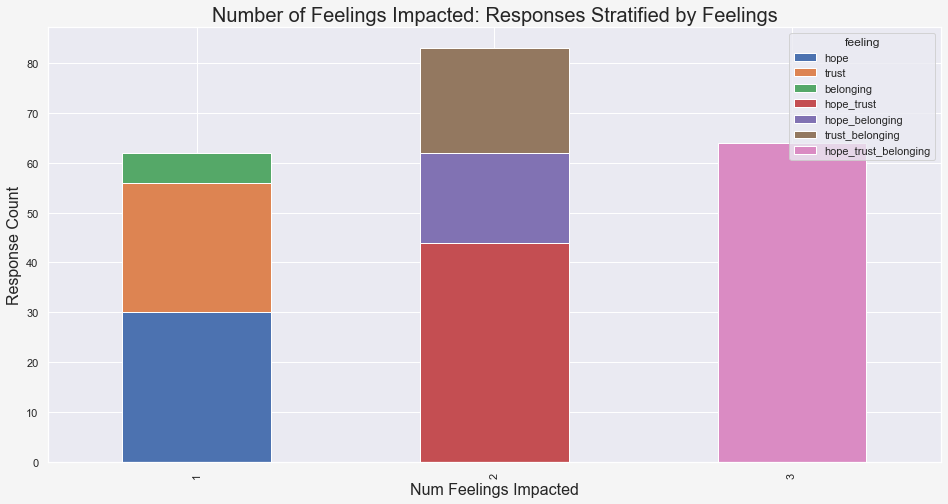

In [210]:
plot_data=feelings_feelingsCount_summary.transpose()
fig, ax = plt.subplots(figsize=(16,8), facecolor='whitesmoke')
a = plot_data.plot(ax=ax, kind='bar',stacked=True)

title = 'Number of Feelings Impacted: Responses Stratified by Feelings'
a.set_title(title,fontsize=20)
a.set_xlabel(' '.join([item.capitalize() for item in a.get_xlabel().split('_')]), fontsize=16)
a.set_ylabel('Response Count',fontsize=16)

#### Notes

In [ ]:
# NOTE 2023/08/15: the previous two figures suggest >=2 feelings are distinct from single feeling responses!
# >=2 feeling responses occur more frequently as the program progresses, seeming to imply greater impact overall
# This makes sense to me: you can feel hopeful but doubt results, trusting but doubt intent, or
# hopeful for results AND trusting in intent.
# As an example, hope_trust grows significantly from communicating to advocating and holds steady at taking_action

# Overall, I see initial excitment, then slight caution as trust grows, then steady growing endorsement with results
# In the end, the "all" action seems to imply you built lasting(?) hope and trust, and a little of all 3 for many
# This cohort - all actions impacted my hope, trust, and belonging - is who I would seek out for capacity building

In [ ]:
# NOTE 2023/08/14: belonging here at penn, belonging in the department, belonging with people I routinely work with?? 

In [ ]:
# NOTE 2023/08/14 (need to clean this up, repetitive): 
"""
engaging: strong impact on hope, hope/trust; large showing of selections of >=2 feelings relative to one feeling
communicating: COMMUNICATION BUILDS TRUST. Tell everyone.
advocating: like engaging but the individual hope impact is smaller, more trust driven, largest showing of single 
            belonging
taking action: dominated by selections of 2 or more feelings; trust is the only remaining single feeling
            

Single feelings seem to have a peak then fall, starting with hope, then trust, then belonging in steps 1,2, and 3, 
respectively. Belonging is not present in step 1 and trust barely shows up. Trust peaks dramatically in step 2, and 
belonging first appears. Belonging peaks in step 3, with large growth in selections of >=2 feelings; trust remains
a strong single emotion. Step 4 has the largest proportion of selections of >=2 emotions and a large and growing 
amount of all three emotions; trust remains as the only strong single emotion.

Selections of >=2 feelings spike in step 1 and then stedily grow over time, first being replaced by trust, then 
more multiple feelings with peaks in hope+trust and single belonging, then driven largely by multiple feelings with a 
peak in trust+belonging.

"All" sort of summarizes the overall trend - the program gave people hope, made solid progress with trust, 
trust+belonging makes a small showing (belonging seems to be the hardest to impact), and a large proportion 
of responses indicating everything the bluecoats did impacted all three of hope, trust, and belonging by the end of 
the program.

"""

### Clustermaps and Heatmaps

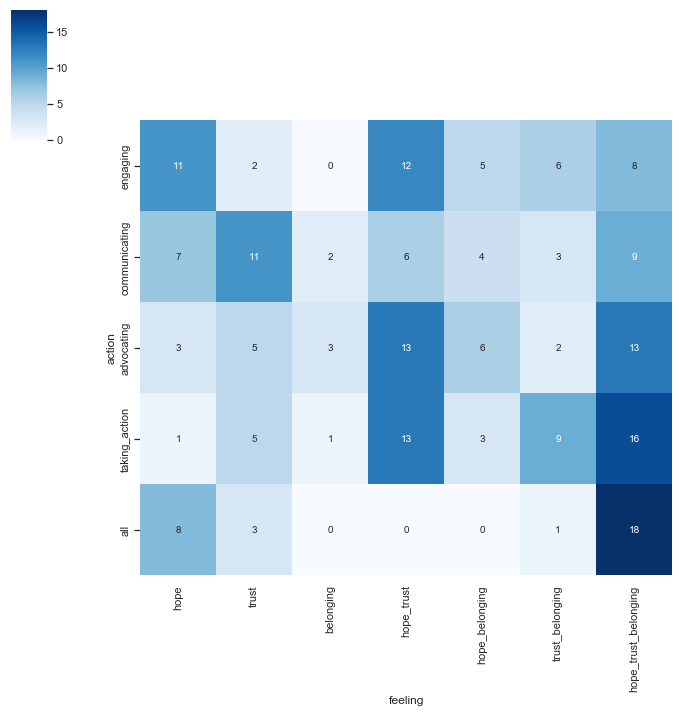

In [30]:
plot_data = htb_categorical_closing_master.groupby(['action','feeling']).count().unstack().fillna(0).droplevel(axis=1, level=0).loc[actions_cols_ordered,feelings_cols_ordered]
g = sns.clustermap(plot_data,cmap='Blues', col_cluster=False, row_cluster=False, annot=True)
#g.fig.axes[2].get_xaxis().tick_top()
#g.fig.axes[2].get_xaxis().set_label_position('top')
g.fig.axes[2].get_yaxis().tick_left()
g.fig.axes[2].get_yaxis().set_label_position('left')

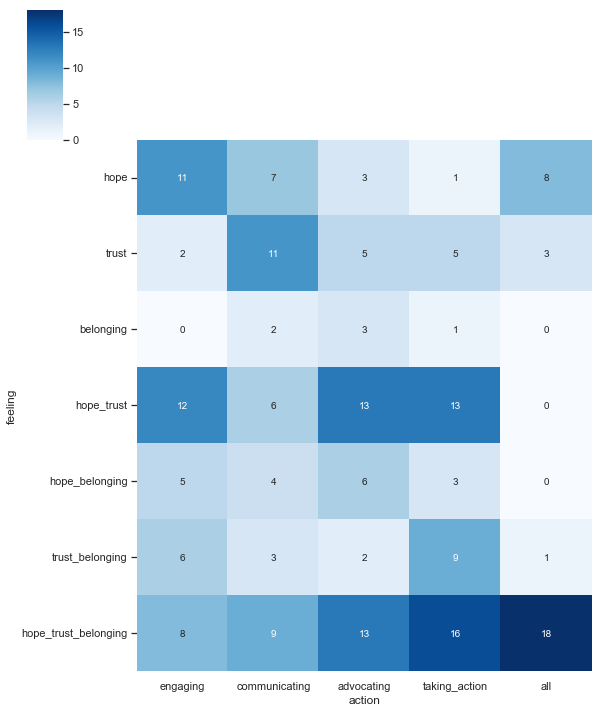

In [151]:
plot_data = htb_categorical_closing_master.groupby(['feeling','action']).count().unstack().fillna(0).droplevel(axis=1,level=0).loc[feelings_cols_ordered,actions_cols_ordered]
g = sns.clustermap(plot_data,cmap='Blues', col_cluster=False, row_cluster=False, annot=True)
#g.fig.axes[2].get_xaxis().tick_top()
#g.fig.axes[2].get_xaxis().set_label_position('top')
g.fig.axes[2].get_yaxis().tick_left()
g.fig.axes[2].get_yaxis().set_label_position('left')

### Correlations

#### HTB Combined
* Can look at correlations between HTB in addition to correlations between actions and feelings

In [202]:
idx_order = actions_cols_ordered + ['hope','trust','belonging']
htb_combined_closing_master.iloc[:,1:].corr().loc[idx_order,idx_order]

,engaging,communicating,advocating,taking_action,all,hope,trust,belonging
engaging,1.0000,-0.2590,-0.2705,-0.2820,-0.2114,0.0852,-0.1242,-0.0927
communicating,-0.2590,1.0000,-0.2627,-0.2738,-0.2053,-0.1468,-0.0586,-0.0933
advocating,-0.2705,-0.2627,1.0000,-0.2860,-0.2144,0.0378,-0.0099,0.0124
taking_action,-0.2820,-0.2738,-0.2860,1.0000,-0.2235,-0.0739,0.1924,0.0903
all,-0.2114,-0.2053,-0.2144,-0.2235,1.0000,0.1132,-0.0078,0.0916
hope,0.0852,-0.1468,0.0378,-0.0739,0.1132,1.0000,-0.1933,0.0141
trust,-0.1242,-0.0586,-0.0099,0.1924,-0.0078,-0.1933,1.0000,0.0911
belonging,-0.0927,-0.0933,0.0124,0.0903,0.0916,0.0141,0.0911,1.0000


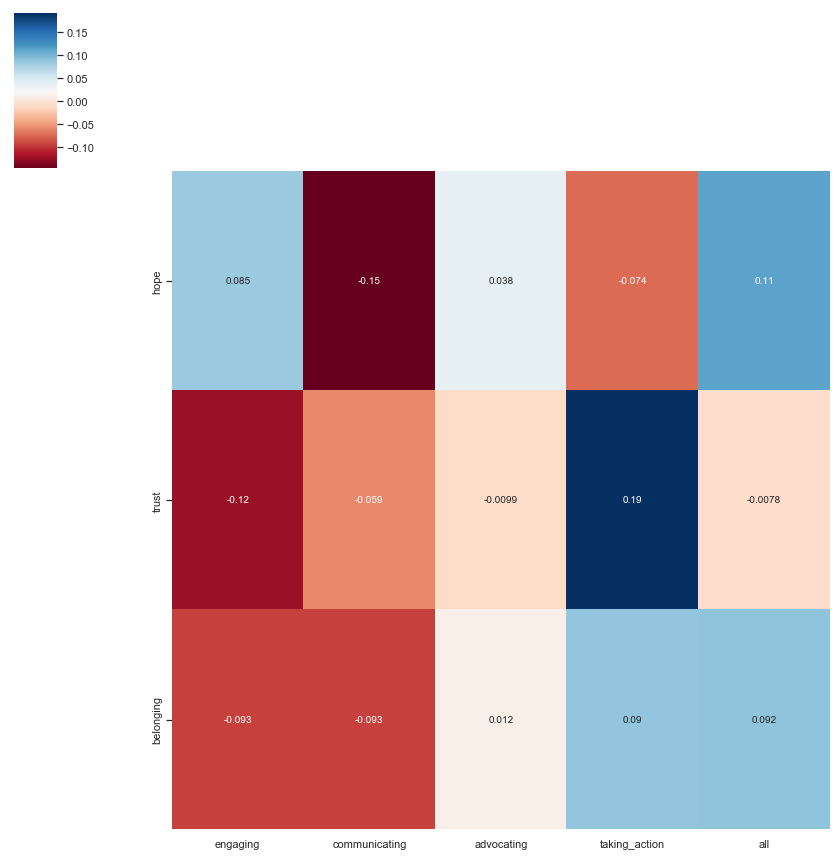

In [203]:
plot_data = htb_combined_closing_master.iloc[:,1:].corr().loc[actions_cols_ordered,['hope','trust','belonging']].transpose()
g = sns.clustermap(plot_data,figsize=(12,12),col_cluster=False, row_cluster=False, annot=True, cmap='RdBu')
#g.fig.axes[2].get_xaxis().tick_top()
#g.fig.axes[2].get_xaxis().set_label_position('top')
g.fig.axes[2].get_yaxis().tick_left()
g.fig.axes[2].get_yaxis().set_label_position('left')

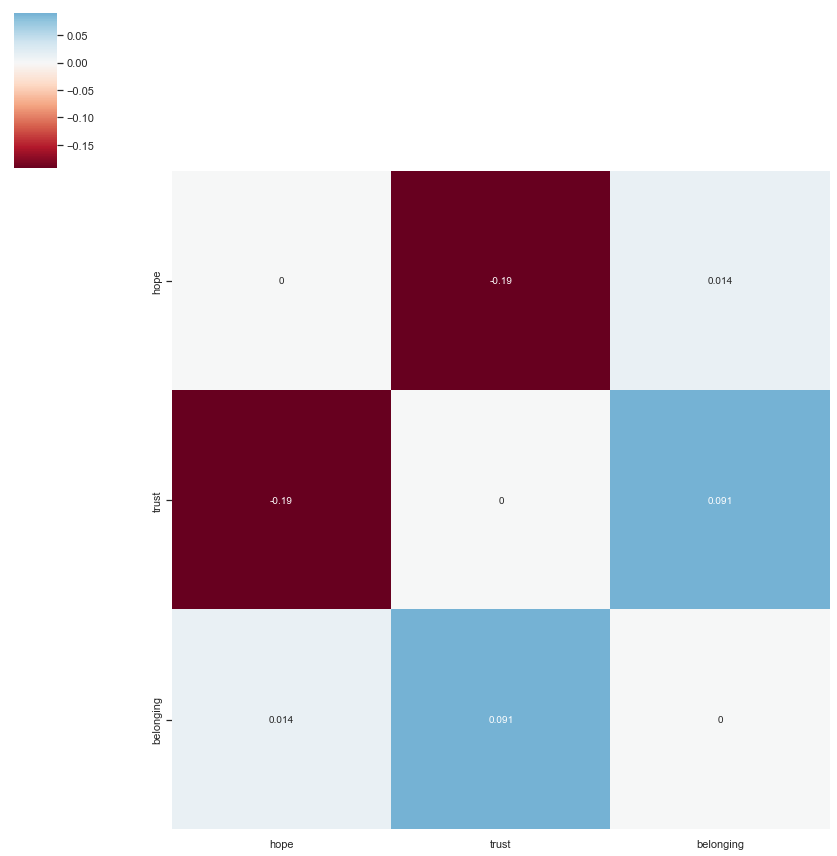

In [204]:
idx_order = actions_cols_ordered + ['hope','trust','belonging']
plot_data = htb_combined_closing_master.iloc[:,1:].corr().loc[['hope','trust','belonging'],['hope','trust','belonging']]
for i in range(len(plot_data)):
    plot_data.iat[i,i]=0
g = sns.clustermap(plot_data,figsize=(12,12),col_cluster=False, row_cluster=False, annot=True, cmap='RdBu',center=0)
#g.fig.axes[2].get_xaxis().tick_top()
#g.fig.axes[2].get_xaxis().set_label_position('top')
g.fig.axes[2].get_yaxis().tick_left()
g.fig.axes[2].get_yaxis().set_label_position('left')

#### HTB Expanded
* Can look at precise correlations between actions and feelings
* In the expanded data format, feelings are mutually exclusive **per response** like actions

In [211]:
idx_order = actions_cols_ordered + feelings_cols_ordered
htb_expanded_closing_master.iloc[:,1:].corr().loc[idx_order,idx_order]

,engaging,communicating,advocating,taking_action,all,hope,trust,belonging,hope_trust,hope_belonging,trust_belonging,hope_trust_belonging
engaging,1.0000,-0.2590,-0.2705,-0.2820,-0.2114,0.1568,-0.1235,-0.0888,0.0788,0.0506,0.0616,-0.1394
communicating,-0.2590,1.0000,-0.2627,-0.2738,-0.2053,0.0331,0.2089,0.0568,-0.0832,0.0163,-0.0485,-0.1000
advocating,-0.2705,-0.2627,1.0000,-0.2860,-0.2144,-0.1148,-0.0211,0.1191,0.1007,0.0881,-0.0976,-0.0197
taking_action,-0.2820,-0.2738,-0.2860,1.0000,-0.2235,-0.1911,-0.0335,-0.0257,0.0808,-0.0460,0.1580,0.0321
all,-0.2114,-0.2053,-0.2144,-0.2235,1.0000,0.1438,-0.0303,-0.0704,-0.2114,-0.1257,-0.0914,0.2609
hope,0.1568,0.0331,-0.1148,-0.1911,0.1438,1.0000,-0.1543,-0.0704,-0.2114,-0.1257,-0.1368,-0.2720
trust,-0.1235,0.2089,-0.0211,-0.0335,-0.0303,-0.1543,1.0000,-0.0648,-0.1946,-0.1157,-0.1260,-0.2504
belonging,-0.0888,0.0568,0.1191,-0.0257,-0.0704,-0.0704,-0.0648,1.0000,-0.0888,-0.0528,-0.0575,-0.1142
hope_trust,0.0788,-0.0832,0.1007,0.0808,-0.2114,-0.2114,-0.1946,-0.0888,1.0000,-0.1585,-0.1726,-0.3431
hope_belonging,0.0506,0.0163,0.0881,-0.0460,-0.1257,-0.1257,-0.1157,-0.0528,-0.1585,1.0000,-0.1026,-0.2040


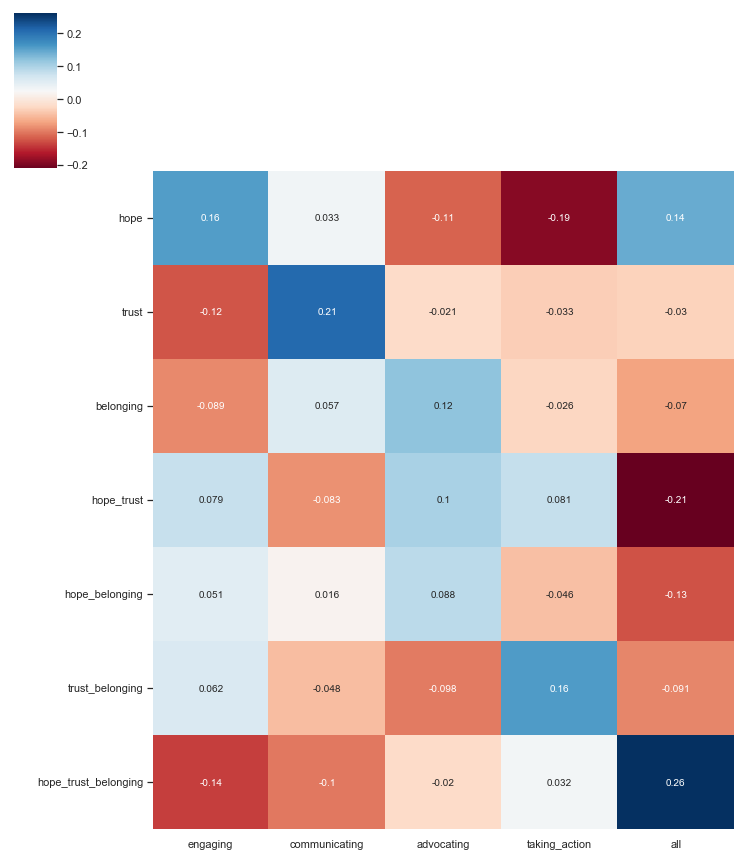

In [221]:
#### Clustering turned off ####
plot_data = htb_expanded_closing_master.iloc[:,1:].corr().loc[actions_cols_ordered,feelings_cols_ordered].transpose()
g = sns.clustermap(plot_data, figsize=(12,12), col_cluster=False, row_cluster=False, annot=True, cmap='RdBu')
#g.fig.axes[2].get_xaxis().tick_top()
#g.fig.axes[2].get_xaxis().set_label_position('top')
g.fig.axes[2].get_yaxis().tick_left()
g.fig.axes[2].get_yaxis().set_label_position('left')

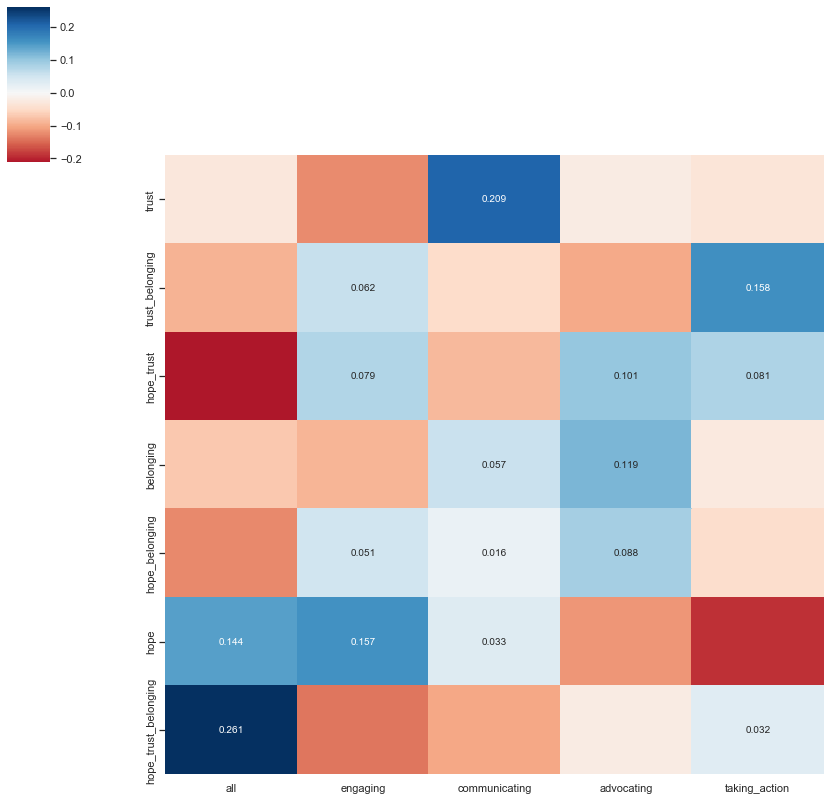

In [272]:
#### Clustering turned on ####
plot_data = htb_expanded_closing_master.iloc[:,1:].corr().loc[actions_cols_ordered,feelings_cols_ordered].transpose()
annot_data = plot_data.copy()
for col in annot_data.columns:
    annot_data[col] = annot_data[col].apply(lambda x: round(x,3) if x>0 else ' ')
    annot_data[col] = annot_data[col].astype('str')
#annot_data = annot_data.iloc[[1, 5, 3, 2, 4, 0, 6],[4, 0, 1, 2, 3]]
g = sns.clustermap(plot_data, figsize=(12,12), col_cluster=True, row_cluster=True, annot=annot_data, fmt='', cmap='RdBu', center=0)
#g.fig.axes[2].get_xaxis().tick_top()
#g.fig.axes[2].get_xaxis().set_label_position('top')
g.fig.axes[2].get_yaxis().tick_left()
g.fig.axes[2].get_yaxis().set_label_position('left')
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)

In [273]:
name = FIGURE_PATH + 'actions_feelings_corr_' + str(datetime.datetime.now().date()).replace('-','')
formats = ['svg','png','pdf']
for file_format in formats:
    save_name = name + '.' + file_format
    g.fig.savefig(save_name,bbox_inches='tight', pad_inches=0, dpi=SAVE_DPI, transparent=True)

In [ ]:
# NOTE 2023/08/15: Can differences in correlation btw combined and expanded help explain multi-feeling distributions
# and relationships (is HT more about H or T for a specific action, or does it not vary, or are they linked as a 
# unique entity that should not be thought of as comprised of H and T independently.)

# Unused / Deprecated Code

In [37]:
"""

htb_categorical_closing_master.groupby(['action','feeling']).count().loc[idx_slice[:,feelings_cols_ordered],:]

"""

"\n\nhtb_categorical_closing_master.groupby(['action','feeling']).count().loc[idx_slice[:,feelings_cols_ordered],:]\n\n"

In [ ]:
"""

#ax.bar(plot_data.index, stacked=True, width=width, color=['#2f4b7c', '#768bbc', '#bfd1ff'])
#ax.bar(plot_data.index, plot_data['hope'], color='#2f4b7c', width=width)
#ax.bar(plot_data.index, plot_data['trust'], color='#768bbc', width=width, bottom=plot_data.loc[:,:'hope'].sum(axis=1).values)
#ax.bar(plot_data.index, plot_data['belonging'], color='#bfd1ff', width=width, bottom=plot_data.loc[:,:'trust'].sum(axis=1).values)

#ax.bar(plot_data.index, plot_data['hope_trust'], color='#665191', width=width, bottom=plot_data.loc[:,:'belonging'].sum(axis=1).values)
#ax.bar(plot_data.index, plot_data['hope_belonging'], color='#a08bc5', width=width, bottom=plot_data.loc[:,:'hope_trust'].sum(axis=1).values)
#ax.bar(plot_data.index, plot_data['trust_belonging'], color='#dcc9fc', width=width, bottom=plot_data.loc[:,:'hope_belonging'].sum(axis=1).values)

#ax.bar(plot_data.index, plot_data['hope_trust_belonging'], color='#a05195', width=width, bottom=plot_data.loc[:,:'trust_belonging'].sum(axis=1).values)

#2f4b7c
#768bbc
#bfd1ff

#665191
#a08bc5
#dcc9fc

#a05195
#ca89bf
#f5c2eb

"""

In [ ]:
"""

a = sns.clustermap(fit_data, row_cluster=False, col_cluster=False, row_colors=[row_colors, row_colors2], col_colors=[col_colors, col_colors2], cmap='binary', linewidths=0, yticklabels=False, figsize=(12,12))
a.cax.set_visible(False)

a.fig.suptitle("Biclustering Facilities with Services", x=0.6, y=0.8, fontsize=18)
a.ax_heatmap.set_xlabel('Services', fontsize=16)
a.ax_heatmap.set_ylabel('Facilities', fontsize=16)

ax = a.ax_heatmap
ax.add_patch(Rectangle((0, 0), len(fit_data.columns), len(fit_data), fill=False, edgecolor='black', lw=2))


"""